# Model training

Baseline is the simplest algorithm that provides predictions without complex computations.
For regression tasks, the Baseline returns the average of the target from training data.

In [2]:
%load_ext jupyter_black

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


In [3]:
from utils import get_training_dataset

In [4]:
# df = get_training_dataset()
# df

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics

from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error

In [6]:
# Read csv file and import to df

df = pd.read_csv("new_model_training_dataset.csv")
df

,typhoon_name,typhoon_year,grid_point_id,wind_speed,total_buildings,total_buildings_damaged,percent_buildings_damaged
0,DURIAN,2006,6262,0.0,57.0,0.0,0.0
1,DURIAN,2006,6264,0.0,379.0,0.0,0.0
2,DURIAN,2006,6265,0.0,23.0,0.0,0.0
3,DURIAN,2006,6428,0.0,156.0,0.0,0.0
4,DURIAN,2006,6429,0.0,90.0,0.0,0.0
...,...,...,...,...,...,...,...
106894,MOLAVE,2020,20554,0.0,173.0,0.0,0.0
106895,MOLAVE,2020,20555,0.0,44.0,0.0,0.0
106896,MOLAVE,2020,20556,0.0,13.0,0.0,0.0
106897,MOLAVE,2020,20557,0.0,401.0,0.0,0.0


array([[<AxesSubplot:title={'center':'percent_buildings_damaged'}>]],
      dtype=object)

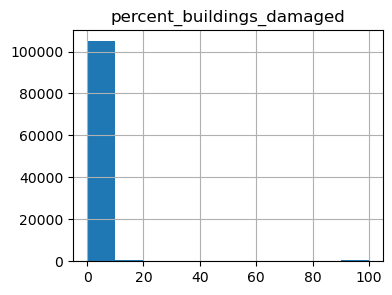

In [7]:
# Show histogram of damage
df.hist(column="percent_buildings_damaged", figsize=(4, 3))

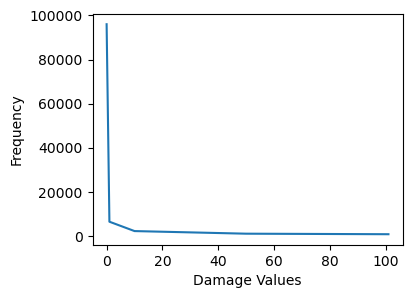

In [8]:
# Hist plot after data stratification
bins2 = [0, 0.00009, 1, 10, 50, 101]
samples_per_bin2, binsP2 = np.histogram(df["percent_buildings_damaged"], bins=bins2)
plt.figure(figsize=(4, 3))
plt.xlabel("Damage Values")
plt.ylabel("Frequency")
plt.plot(binsP2[1:], samples_per_bin2)

In [9]:
# Remove zeros from wind_speed
df = df[(df[["wind_speed"]] != 0).any(axis=1)]

df = df.drop(columns=["grid_point_id", "typhoon_year"])
df

,typhoon_name,wind_speed,total_buildings,total_buildings_damaged,percent_buildings_damaged
108,DURIAN,21.104601,126.0,0.0,0.0
109,DURIAN,19.968266,112.0,0.0,0.0
110,DURIAN,18.926342,8.0,0.0,0.0
127,DURIAN,25.354383,42.0,0.0,0.0
128,DURIAN,23.811114,455.0,0.0,0.0
...,...,...,...,...,...
106170,MOLAVE,18.406846,3.0,0.0,0.0
106338,MOLAVE,18.014052,1483.0,0.0,0.0
106381,MOLAVE,17.877636,5986.0,0.0,0.0
106428,MOLAVE,17.778820,646.0,0.0,0.0


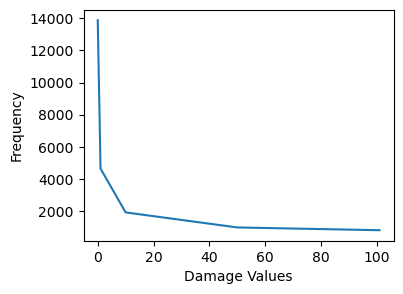

In [10]:
# Hist plot after removing rows where windspeed is 0
bins2 = [0, 0.00009, 1, 10, 50, 101]
samples_per_bin2, binsP2 = np.histogram(df["percent_buildings_damaged"], bins=bins2)
plt.figure(figsize=(4, 3))
plt.xlabel("Damage Values")
plt.ylabel("Frequency")
plt.plot(binsP2[1:], samples_per_bin2)

In [11]:
print(samples_per_bin2)
print(binsP2)

[13871  4647  1926   992   819]
[0.00e+00 9.00e-05 1.00e+00 1.00e+01 5.00e+01 1.01e+02]


In [12]:
# Check the bins' intervalls
# df["percent_buildings_damaged"].value_counts(bins=binsP2)

In [13]:
bin_index2 = np.digitize(df["percent_buildings_damaged"], bins=binsP2)

In [14]:
y_input_strat = bin_index2

In [15]:
features = ["wind_speed", "total_buildings", "total_buildings_damaged"]

# Split X and y from dataframe features
X = df[features]
display(X.columns)
y = df["percent_buildings_damaged"]

scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

Index(['wind_speed', 'total_buildings', 'total_buildings_damaged'], dtype='object')

In [16]:
# Define train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, df["percent_buildings_damaged"], stratify=y_input_strat, test_size=0.2
)

# create a dummy regressor
dummy_reg = DummyRegressor(strategy="mean")

# fit it on the training set
dummy_reg.fit(X_train, y_train)

bin_index_test = np.digitize(y_test, bins=binsP2)
bin_index_train = np.digitize(y_train, bins=binsP2)

# make predictions on the test set
y_pred = dummy_reg.predict(X_test)

# Estimation of RMSE for test data per each bin
mse_idx1 = mean_squared_error(y_test[bin_index_test == 1], y_pred[bin_index_test == 1])
rmse_1 = np.sqrt(mse_idx1)

mse_idx2 = mean_squared_error(y_test[bin_index_test == 2], y_pred[bin_index_test == 2])
rmse_2 = np.sqrt(mse_idx2)

mse_idx3 = mean_squared_error(y_test[bin_index_test == 3], y_pred[bin_index_test == 3])
rmse_3 = np.sqrt(mse_idx3)

mse_idx4 = mean_squared_error(y_test[bin_index_test == 4], y_pred[bin_index_test == 4])
rmse_4 = np.sqrt(mse_idx4)

mse_idx5 = mean_squared_error(y_test[bin_index_test == 5], y_pred[bin_index_test == 5])
rmse_5 = np.sqrt(mse_idx5)

print("Dummy RMSE per bin_1:", rmse_1)
print("Dummy RMSE per bin_2:", rmse_2)
print("Dummy RMSE per bin_3:", rmse_3)
print("Dummy RMSE per bin_4:", rmse_4)
print("Dummy RMSE per bin_5:", rmse_5)

Dummy RMSE per bin_1: 4.695203196186884
Dummy RMSE per bin_2: 4.522498672183052
Dummy RMSE per bin_3: 2.6361966435608237
Dummy RMSE per bin_4: 23.366043162102205
Dummy RMSE per bin_5: 85.78635973801136


In [17]:
# create a dummy regressor
dummy_reg = DummyRegressor(strategy="mean")

# fit it on the training set
dummy_reg.fit(X_train, y_train)

# make predictions on the test set
y_pred = dummy_reg.predict(X_test)

# calculate root mean squared error
mse = mean_squared_error(y_test, y_pred)

rmse = np.sqrt(mse)
print("Dummy RMSE:", rmse)

Dummy RMSE: 17.721712775194522
